In [2]:
import argparse
from collections import defaultdict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys

from joblib import Parallel, delayed
import numpy as np
# import ray
# # use fewer CPUs so the OS doesn't run out of processes
# ray.init(num_cpus=16)
# import modin.pandas as pd
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

log = sys.stdout

## Functions:

In [3]:
def all_unique(iterable):
    """
    Input: an iterable
    Output: whether or not it doesn't contain duplicates
    """
    filtered = np.unique(iterable)
    return len(iterable) == len(filtered)


def parse_header(path_to_vcf):
    """ 
    Input: path to vcf
    Output: list of the column names
    """
    try:
        n_lines_to_skip = int(subprocess.check_output(
            "grep -Ec '^#{{2}}' {}".format(path_to_vcf), 
            shell=True
        ).decode("utf-8"))
    except subprocess.CalledProcessError as err: 
        if err.returncode == 1:
            n_lines_to_skip = 0
        else: 
            raise err
    header_line = subprocess.check_output(
        "sed -n '{}p' {}".format(n_lines_to_skip + 1, path_to_vcf), 
        shell=True
    ).decode("utf-8").strip("#\n")
    print(header_line)
    column_names = header_line.split('\t')
    return column_names, n_lines_to_skip


def read_vcf(path_to_vcf, usecols=None, **pd_kwargs):
    """
    Skip metadata and read only the specified columns from th
    """
    column_names, n_lines_to_skip = parse_header(path_to_vcf)
    if usecols is not None:
        usecols[0] = "#" + usecols[0]
    resulting_df = pd.read_csv(
        path_to_vcf, sep='\t', 
        skiprows=n_lines_to_skip, 
        usecols=usecols,
        **pd_kwargs
    )
    resulting_df.rename(columns={
        resulting_df.columns[0] 
        : resulting_df.columns[0].strip('#')
       }, inplace=True
    )
    return resulting_df


def dump_pkl(obj, path):
    with open(path, "wb") as outfile:
        pickle.dump(obj, outfile)
        
        
def load_pkl(path):
    with open(path, "rb") as infile:
        return pickle.load(infile)

## Reading data

In [4]:
# raw_vcf = "full_na_raw.vcf"
raw_vcf = "phased_raw.tsv"
# phasing_vcf = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/whatshap_phasing/outs/phased_wgs.vcf"
phasing_vcf = "phasing.vcf"
ref_genome = "/icgc/dkfzlsdf/analysis/B260/users/n790i/tools/binning_the_genome/humangenes_biomart_GRCh37p13.sort.bed"
tmp_dir = "tmp_ase"

In [4]:
!mkdir "tmp_ase"

mkdir: cannot create directory ‘tmp_ase’: File exists


In [5]:
%%time
genome_df = pd.read_csv(
    ref_genome, 
    sep='\t', 
    header=0, 
    names=parse_header(ref_genome)[0]
) 
phasing_df = pd.read_csv(
    phasing_vcf,
    sep='\t'
)
# phasing_df.rename(columns={
#         "sample_blood_XI046_ST_LFS_1" 
#         : "INFO"
#     }, inplace=True
# )
# is_phased = np.fromiter(
#     (("0|1" in s) or ("1|0" in s) 
#     for s in phasing_df.INFO),
#     dtype=bool
# )
# assert is_phased.size == phasing_df.shape[0], "phasing_vcf contains non-phased entries"
# phasing_df = phasing_df[is_phased]
# raw_df = pd.read_csv(raw_vcf, sep='\t').to_sparse()
raw_df = pd.read_pickle("phased_raw.pkl")

chr	start	end	GeneName	GeneID
CPU times: user 7.96 s, sys: 2.49 s, total: 10.4 s
Wall time: 13.7 s


In [6]:
%%time
barcode_list = []
barcode_pattern = r"^(A|G|C|T)+-1"
for colname in tqdm_notebook(raw_df.columns, desc="cell barcode"):
    if re.match(barcode_pattern, colname) is not None:
        barcode_list.append(colname)
        # dirty hack to handle NaN: NaN != NaN. 
        # For some reason, it hangs if I try selecting entries that aren't NaN
        raw_df[colname] = raw_df[colname].apply(lambda s: ':'.join(s.split(":")[2:4]) if s==s else s) 


CPU times: user 44.7 s, sys: 4.67 s, total: 49.4 s
Wall time: 48.7 s


In [7]:
raw_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 1552849 entries, 0 to 1552848
Columns: 412 entries, CHROM to PHASE
dtypes: Sparse[float64, nan](1), Sparse[int64, nan](4), Sparse[object, nan](407)
memory usage: 502.3 MB


In [8]:
print("genome_df, {}:\n{}".format(genome_df.shape, genome_df.head()), file=log)
print("raw_df, {}:\n{}".format(raw_df.shape, raw_df.head()), file=log)
print("phasing_df, {}:\n{}".format(phasing_df.shape, phasing_df.head()), file=log)
print("loaded everything into RAM", file=log)

genome_df, (57773, 5):
  chr  start    end    GeneName           GeneID
0   1  11869  14412     DDX11L1  ENSG00000223972
1   1  14363  29806      WASH7P  ENSG00000227232
2   1  29554  31109  MIR1302-10  ENSG00000243485
3   1  34554  36081     FAM138A  ENSG00000237613
4   1  52473  54936      OR4G4P  ENSG00000268020
raw_df, (1552849, 412):
   CHROM        POS REF ALT AAACCTGCACGACTAT-1 AAACCTGTCTTGCGAA-1  \
0     10   10000018   A   G                NaN                NaN   
1     10  100004360   G   A                NaN                NaN   
2     10  100004441   G   C                NaN                NaN   
3     10  100004996   G   A                NaN                NaN   
4     10   10001085   G   A                0:1                NaN   

  AAACGGGAGTGTTGAA-1 AAACGGGGTACTCACA-1 AAAGCAAAGCTGGTCC-1 AAAGCAAAGGCCATAG-1  \
0                NaN                NaN                0:1                NaN   
1                NaN                NaN                NaN                NaN   
2

In [9]:
raw_df.to_pickle("phased_raw.pkl")

In [10]:
# raw_df.drop(columns=["ID", "QUAL", "FILTER", "FORMAT"], inplace=True)

In [11]:
# raw_df.to_csv("full_na_raw.vcf", sep='\t', index=False, na_rep="NA")

## Extracting SNPs

In [8]:
%%time
raw_snps = [
    "{}_{}".format(chrom, pos) 
    for chrom, pos in 
    raw_df[["CHROM", "POS"]].values
]
phasing_snps = [
    "{}_{}".format(chrom, pos) 
    for chrom, pos in 
    phasing_df[["CHROM", "POS"]].values
]
assert all_unique(raw_snps) and all_unique(phasing_snps), "duplicate SNPs detected (wtf?)"
common_snps = set(raw_snps) & set(phasing_snps)
print("{} SNPs in the sample, {} SNPs in the phasing data, {} common SNPs ({:.2f}%)".format(
    raw_df.shape[0], phasing_df.shape[0], 
    len(common_snps), 100 * len(common_snps) / raw_df.shape[0]
))
print("raw_snps: ", raw_snps[:10], file=log)
print("phasing_snps: ", phasing_snps[:10], file=log)
print("common_snps: ", list(common_snps)[:10], file=log)

1552849 SNPs in the sample, 1556362 SNPs in the phasing data, 1552849 common SNPs (100.00%)
raw_snps:  ['10_10000018', '10_100004360', '10_100004441', '10_100004996', '10_10001085', '10_10001208', '10_100012739', '10_100012890', '10_100013244', '10_100013438']
phasing_snps:  ['1_14464', '1_14907', '1_14976', '1_15118', '1_15211', '1_15447', '1_16068', '1_16103', '1_16298', '1_16378']
common_snps:  ['18_24670054', '18_23169856', '3_30474246', '8_3295238', '19_20232863', '1_218045192', '4_190553244', '4_96806267', '5_80104368', '9_7750063']
CPU times: user 15.6 s, sys: 9.89 s, total: 25.5 s
Wall time: 29.2 s


## Dropping out SNPs with unknown phasing

In [40]:
%%time
raw_df["snp"] = raw_snps
phasing_df["snp"] = phasing_snps
raw_df = raw_df[raw_df.snp.isin(common_snps)]
phasing_df = phasing_df[phasing_df.snp.isin(common_snps)]
assert raw_df.shape[0] == phasing_df.shape[0], "filtering by common SNP gone wrong: unequal number of rows"
raw_df.sort_values(by="snp", inplace=True)
phasing_df.sort_values(by="snp", inplace=True)
print("filtered the dataframes", file=log)

/software/anaconda3/5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


filtered the dataframes
CPU times: user 19.7 s, sys: 2min 14s, total: 2min 33s
Wall time: 4min 29s


## Extrating phasing information

In [ ]:
phasing_df["phase"] = phasing_df.INFO.apply(lambda s: s.split(":")[0] == '1|0')
phasing_df.drop("INFO", axis=1, inplace=True)
print("extracted the phase labels", file=log)

## Integrating phasing information into main DataFrame

In [11]:
raw_df["PHASE"] = phasing_df["PHASE"]
del phasing_df # now we don't need it any longer
print("dropped the phasing_df", file=log)

dropped the phasing_df


In [86]:
raw_df.to_csv("phased_raw.tsv", index=False, sep='\t')

## Mapping SNPs to genes (and the other way around)

In [11]:
genome_df.head()

,chr,start,end,GeneName,GeneID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020


In [12]:
snp_df = raw_df[["CHROM", "POS"]]

In [49]:
raw_df.ALT.value_counts()

T    400995
A    400115
C    376520
G    375219
Name: ALT, dtype: int64

In [ ]:
chrom_to_genes = {}

for chrom in genome_df["chr"].value_counts().keys():
    chrom_to_genes[chrom] = genome_df[genome_df.chr == chrom]

In [59]:
%%time

def pool_handler(snp_tuple):
    chrom, pos = snp_tuple
    pos -= 1 # 1-based to 0-based
    genes = chrom_to_genes[str(chrom)]
    mask = (genes.start <= pos) & (pos < genes.end)
    return ';'.join(genes[mask].GeneID)

pool = mp.Pool(16)
result = pool.map(pool_handler, snp_df.values)
pool.close()
pool.join()

CPU times: user 20.7 s, sys: 8.96 s, total: 29.6 s
Wall time: 4min 1s


In [76]:
snp_to_genes, gene_to_snps = {}, defaultdict(list)
for i, row in enumerate(snp_df.values):
    chrom, pos = row
    snp = f"{chrom}_{pos}"
    snp_to_genes[snp] = result[i].split(";") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)
    
with open("snp_to_genes.pkl", "wb") as outfile:
    pickle.dump(snp_to_genes, outfile)
    
with open("gene_to_snps.pkl", "wb") as outfile:
    pickle.dump(gene_to_snps, outfile)

In [ ]:
for c in raw_df.columns:
    print(c, raw_df[c].isna().sum() / raw_df.shape[0] * 100)

CHROM 0.0
POS 0.0
REF 0.0
ALT 0.0
AAACCTGCACGACTAT-1 92.79749673020365
AAACCTGTCTTGCGAA-1 94.27355782822411
AAACGGGAGTGTTGAA-1 98.0235682928604
AAACGGGGTACTCACA-1 94.13787174412967
AAAGCAAAGCTGGTCC-1 95.34011355901313
AAAGCAAAGGCCATAG-1 95.79398898411887
AACACGTCACTGCGCA-1 96.73806017198066
AACACGTTCGATAGTC-1 96.63811484568042
AACCATGGTAAGTGTA-1 93.24654232317502
AACTCCCAGAGTAATC-1 94.5939366931363
AACTCCCAGGGATTCG-1 95.72025354686772
AACTCTTGTCCGATGC-1 95.82792660458294
AACTCTTTCAAGTTGC-1 94.0978807340572
AAGACCTCACAAACTC-1 95.38403283255488
AAGCCGCCAGACACGA-1 94.91734225285265
AAGGCAGCAAGCAAGC-1 93.5615761738585
AAGGCAGTCAGATTCG-1 95.95659333264213
AAGTCTGAGCACAGGT-1 92.84244636793404
AAGTCTGTCTACCGTC-1 93.64973670975093
AATCGGTTCGCGATGC-1 94.40067901000033
ACACCCTCATACGTTG-1 96.26918006837755
ACACCGGAGGCATATA-1 96.09962076158081
ACACTGACAGGATCCC-1 98.49702063755072
ACACTGAGTGCGGTAA-1 95.46671955869502
ACAGCTACATAGTGTC-1 94.73979762359379
ACATACGCACTGGCCA-1 97.71368626312024
ACATACGT

## Loading barcoded columns and extracting read counts

In [19]:
%%time
# extract barcoded columns
# parse those and split each such column into two different ones: DP and AD
counts_df = pd.SparseDataFrame()
phase = raw_df.PHASE.values.to_dense()
male_alt = phase == 1

for barcode in tqdm_notebook(barcode_list, desc="cell_barcode"):
    column = raw_df[barcode].to_dense()
    ad = column.apply(
        lambda s: int(s.split(":")[0]) if s==s else s
    ).astype(np.float32)
    dp = column.apply(
        lambda s: int(s.split(":")[1]) if s==s else s
    ).astype(np.float32)    
    ad[male_alt] = dp[male_alt] - ad[male_alt]
    counts_df[f"{barcode}_ad"] = ad.to_sparse()
    counts_df[f"{barcode}_dp"] = dp.to_sparse()

CPU times: user 11min 24s, sys: 3.14 s, total: 11min 27s
Wall time: 11min 26s


In [20]:
counts_df.head()

,AAACCTGCACGACTAT-1_ad,AAACCTGCACGACTAT-1_dp,AAACCTGTCTTGCGAA-1_ad,AAACCTGTCTTGCGAA-1_dp,AAACGGGAGTGTTGAA-1_ad,AAACGGGAGTGTTGAA-1_dp,AAACGGGGTACTCACA-1_ad,AAACGGGGTACTCACA-1_dp,AAAGCAAAGCTGGTCC-1_ad,AAAGCAAAGCTGGTCC-1_dp,...,TTGAACGCAGCGATGA-1_ad,TTGAACGCAGCGATGA-1_dp,TTGCGTCCAACGGCTC-1_ad,TTGCGTCCAACGGCTC-1_dp,TTGGAACGTTCTGTCC-1_ad,TTGGAACGTTCTGTCC-1_dp,TTTATGCCATGTTTCT-1_ad,TTTATGCCATGTTTCT-1_dp,TTTCCTCGTGATCCTA-1_ad,TTTCCTCGTGATCCTA-1_dp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,2.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN


In [21]:
counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 1552849 entries, 0 to 1552848
Columns: 808 entries, AAACCTGCACGACTAT-1_ad to TTTCCTCGTGATCCTA-1_dp
dtypes: Sparse[float32, nan](808)
memory usage: 579.4 MB


In [22]:
counts_df.to_pickle("counts_df.pkl")

## Aggregating read counts over genes

In [23]:
gene_to_snps = load_pkl("gene_to_snps.pkl")
snp_to_genes = load_pkl("snp_to_genes.pkl")
snp_counts_df = pd.read_pickle("counts_df.pkl")
gene_counts_df = pd.SparseDataFrame()
snp_list = raw_df.SNP.values

In [24]:
snp_counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 1552849 entries, 0 to 1552848
Columns: 808 entries, AAACCTGCACGACTAT-1_ad to TTTCCTCGTGATCCTA-1_dp
dtypes: Sparse[float32, nan](808)
memory usage: 579.4 MB


In [25]:
snp_to_idx = {snp : i for i, snp in tqdm_notebook(enumerate(snp_list))}

In [26]:
snp_counts_df.head()

,AAACCTGCACGACTAT-1_ad,AAACCTGCACGACTAT-1_dp,AAACCTGTCTTGCGAA-1_ad,AAACCTGTCTTGCGAA-1_dp,AAACGGGAGTGTTGAA-1_ad,AAACGGGAGTGTTGAA-1_dp,AAACGGGGTACTCACA-1_ad,AAACGGGGTACTCACA-1_dp,AAAGCAAAGCTGGTCC-1_ad,AAAGCAAAGCTGGTCC-1_dp,...,TTGAACGCAGCGATGA-1_ad,TTGAACGCAGCGATGA-1_dp,TTGCGTCCAACGGCTC-1_ad,TTGCGTCCAACGGCTC-1_dp,TTGGAACGTTCTGTCC-1_ad,TTGGAACGTTCTGTCC-1_dp,TTTATGCCATGTTTCT-1_ad,TTTATGCCATGTTTCT-1_dp,TTTCCTCGTGATCCTA-1_ad,TTTCCTCGTGATCCTA-1_dp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,2.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN


In [27]:
gene_to_snp_ids = {gene : [snp_to_idx[snp] for snp in snp_list] 
                   for gene, snp_list in tqdm_notebook(gene_to_snps.items(), desc="mapping refinement")}

for barcode in tqdm_notebook(barcode_list, desc="cell_barcode processing"):
    gene_to_ad, gene_to_dp = [], []
    ad = snp_counts_df[f"{barcode}_ad"].values.to_dense()
    dp = snp_counts_df[f"{barcode}_dp"].values.to_dense()
    for gene in gene_to_snps.keys():
        snp_ids = gene_to_snp_ids[gene]
        gene_to_ad.append(np.nansum(ad[snp_ids]))
        gene_to_dp.append(np.nansum(dp[snp_ids]))
    gene_counts_df[f"{barcode}_ad"] = gene_to_ad
    gene_counts_df[f"{barcode}_dp"] = gene_to_dp

In [28]:
gene_counts_df.insert(column="GENE", loc=0, value=list(gene_to_snps.keys()))
gene_counts_df.shape

(23037, 809)

In [29]:
gene_counts_df.head()

,GENE,AAACCTGCACGACTAT-1_ad,AAACCTGCACGACTAT-1_dp,AAACCTGTCTTGCGAA-1_ad,AAACCTGTCTTGCGAA-1_dp,AAACGGGAGTGTTGAA-1_ad,AAACGGGAGTGTTGAA-1_dp,AAACGGGGTACTCACA-1_ad,AAACGGGGTACTCACA-1_dp,AAAGCAAAGCTGGTCC-1_ad,...,TTGAACGCAGCGATGA-1_ad,TTGAACGCAGCGATGA-1_dp,TTGCGTCCAACGGCTC-1_ad,TTGCGTCCAACGGCTC-1_dp,TTGGAACGTTCTGTCC-1_ad,TTGGAACGTTCTGTCC-1_dp,TTTATGCCATGTTTCT-1_ad,TTTATGCCATGTTTCT-1_dp,TTTCCTCGTGATCCTA-1_ad,TTTCCTCGTGATCCTA-1_dp
0,ENSG00000166024,2.0,5.0,6.0,7.0,0.0,0.0,1.0,3.0,0.0,...,2.0,2.0,2.0,4.0,3.0,7.0,3.0,3.0,7.0,10.0
1,ENSG00000138131,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,ENSG00000230928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000119943,3.0,6.0,0.0,4.0,1.0,2.0,6.0,10.0,0.0,...,1.0,1.0,0.0,0.0,3.0,6.0,0.0,0.0,5.0,5.0
4,ENSG00000107521,0.0,6.0,1.0,1.0,0.0,0.0,9.0,13.0,0.0,...,1.0,1.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0


In [111]:
gene_ordering = {gene : i for i, gene in enumerate(genome_df.GeneID)}
gene_counts_df["GENE_IDX"] = [gene_ordering[gene] for gene in gene_counts_df.GENE]
gene_counts_df.sort_values(by="GENE_IDX", inplace=True)
gene_counts_df.drop(columns=["GENE_IDX"], inplace=True)
gene_counts_df.reset_index(drop=True, inplace=True)
gene_counts_df.head()

,GENE,AAACCTGCACGACTAT-1_ad,AAACCTGCACGACTAT-1_dp,AAACCTGTCTTGCGAA-1_ad,AAACCTGTCTTGCGAA-1_dp,AAACGGGAGTGTTGAA-1_ad,AAACGGGAGTGTTGAA-1_dp,AAACGGGGTACTCACA-1_ad,AAACGGGGTACTCACA-1_dp,AAAGCAAAGCTGGTCC-1_ad,...,TTGAACGCAGCGATGA-1_ad,TTGAACGCAGCGATGA-1_dp,TTGCGTCCAACGGCTC-1_ad,TTGCGTCCAACGGCTC-1_dp,TTGGAACGTTCTGTCC-1_ad,TTGGAACGTTCTGTCC-1_dp,TTTATGCCATGTTTCT-1_ad,TTTATGCCATGTTTCT-1_dp,TTTCCTCGTGATCCTA-1_ad,TTTCCTCGTGATCCTA-1_dp
0,ENSG00000227232,0.0,0.0,0.0,0.0,1.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000268020,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
2,ENSG00000240361,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,0.0,2.0,1.0,2.0,2.0,3.0,0.0,0.0,2.0,...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0
4,ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
for colname in gene_counts_df.columns:
    if re.match(barcode_pattern, colname) is None:
        print(colname)

GENE


In [112]:
gene_counts_df.to_pickle("gene_counts.pkl")

## Aggregating by cell barcode

In [172]:
gene_counts_df = pd.read_pickle("gene_counts.pkl")
cell_gene_counts = pd.DataFrame()
cell_gene_counts["GENE"] = gene_counts_df["GENE"]

In [173]:
clustering_tsv = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/single_cell_integration_dna_rna/scrna_vs_scdna/outs/Sample1_scDNA_clustering_info.tsv"

In [174]:
clustering_df = pd.read_csv(clustering_tsv, sep='\t', usecols=["cl_hierarchical", "barcode"])
clustering_df.head()

,cl_hierarchical,barcode
0,1,AAACCTGTCTTGCGAA-1
1,2,AACTCCCAGGGATTCG-1
2,1,CACCTTGAGAAGGACA-1
3,3,CACCTTGAGGTAAACT-1
4,3,CAGAGAGGTTCCCACT-1


In [175]:
barcode_to_cluster = {
    barcode : cluster_id
    for cluster_id, barcode in
    clustering_df.values
}

In [176]:
n_clusters = clustering_df.cl_hierarchical.value_counts().size
n_clusters

3

In [177]:
n_genes = gene_counts_df.shape[0]
for i in range(1, n_clusters + 1):
    cell_gene_counts[f"cluster_{i}_ad"] = np.zeros(n_genes)
    cell_gene_counts[f"cluster_{i}_dp"] = np.zeros(n_genes)
cell_gene_counts.head()

,GENE,cluster_1_ad,cluster_1_dp,cluster_2_ad,cluster_2_dp,cluster_3_ad,cluster_3_dp
0,ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000240361,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
cluster_label_list = clustering_df.cl_hierarchical.unique()
cluster_label_list 

array([1, 2, 3])

In [179]:
for cluster_label in tqdm_notebook(cluster_label_list, desc="cluster"): 
    barcode_group = clustering_df.query(f"cl_hierarchical == {cluster_label}").barcode
    for barcode in tqdm_notebook(barcode_group, desc="barcodes in cluster"):
        prefix = f"cluster_{cluster_label}"
        cell_gene_counts[prefix + "_dp"] += gene_counts_df[f"{barcode}_dp"]
        cell_gene_counts[prefix + "_ad"] += gene_counts_df[f"{barcode}_ad"]
        

In [180]:
cell_gene_counts.head()

,GENE,cluster_1_ad,cluster_1_dp,cluster_2_ad,cluster_2_dp,cluster_3_ad,cluster_3_dp
0,ENSG00000227232,103.0,149.0,3.0,9.0,45.0,54.0
1,ENSG00000268020,27.0,36.0,2.0,5.0,10.0,14.0
2,ENSG00000240361,19.0,49.0,4.0,7.0,5.0,11.0
3,ENSG00000238009,236.0,462.0,19.0,35.0,62.0,141.0
4,ENSG00000239945,12.0,23.0,3.0,4.0,3.0,11.0


In [181]:
cell_gene_counts.to_pickle("cell_gene_counts.pkl")

In [182]:
ase_df = pd.DataFrame(columns=[i+1 for i in range(n_clusters)])
ase_df.insert(0, "GENE", cell_gene_counts["GENE"])
for i in range(n_clusters):
       ase_df[i+1] = (cell_gene_counts[f"cluster_{i+1}_ad"] 
                    / cell_gene_counts[f"cluster_{i+1}_dp"])
ase_df.head()

,GENE,1,2,3
0,ENSG00000227232,0.691275,0.333333,0.833333
1,ENSG00000268020,0.750000,0.400000,0.714286
2,ENSG00000240361,0.387755,0.571429,0.454545
3,ENSG00000238009,0.510823,0.542857,0.439716
4,ENSG00000239945,0.521739,0.750000,0.272727


In [183]:
ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 4 columns):
GENE    23037 non-null Sparse[object, nan]
1       22998 non-null Sparse[float64, nan]
2       20419 non-null Sparse[float64, nan]
3       22588 non-null Sparse[float64, nan]
dtypes: Sparse[float64, nan](3), Sparse[object, nan](1)
memory usage: 720.0 KB


<Figure size 1440x2160 with 0 Axes>

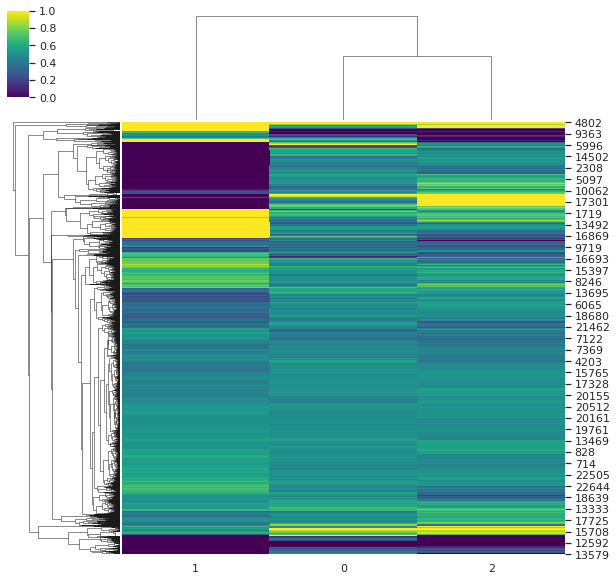

In [184]:
plt.figure(figsize=(20,30))
sns.clustermap(
    ase_df\
    .drop(columns=["GENE"])\
    .fillna(value=0)\
    .astype(np.float32)\
    .values,
    cmap="viridis"
);

In [185]:
ase_df.to_pickle("ase_df.pkl")